# Introduction:
In this last section, various tree based models are evaluated and best model will be selected based on lowest RMSE. Decision Tree, Random Forest, Gradient boosting , XGboost regressor are used for study. 

Filtered and engineered train and test data from third section(Ref:https://www.kaggle.com/lajari/sec3-eda-fe-categorical) has been used. In order to use categorical data in model, it need to be converted to numeric i.e. encode. Simple label encoding is sufficient for tree based modelling as well as we do not require feature scaling as they don't have much impact on performance of tree based model. As well as in this section we are mapping features directly to SalePrice unlike Log version as in previous section.

# Load Data:

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.preprocessing import LabelEncoder
pd.set_option('max_columns',100)

In [2]:
train = pd.read_csv('/kaggle/input/sec3-eda-fe-categorical/eng_filt_train.csv')
test = pd.read_csv('/kaggle/input/sec3-eda-fe-categorical/eng_filt_test.csv')
train.shape,test.shape

((1425, 84), (1459, 82))

In [3]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley',
       'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorc

# Prepare Data:

Simple label encoding has been applied to categorical features and other numeric features kept as it is.

In [4]:
train['MSSubClass'] = train['MSSubClass'].astype('category')
test['MSSubClass'] = test['MSSubClass'].astype('category')
traintest = pd.concat([train,test],axis=0,ignore_index=True)
cats = traintest.select_dtypes(include = ['object','category']).columns

le =LabelEncoder()
traintest[cats] = traintest[cats].apply(le.fit_transform)
traintest.drop(['LogPrice','SalePrice','Id'],axis=1,inplace=True)
trs = traintest[:1425]
tes = traintest[1425:]

traintest.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,RoomSize,LotPerimeter,YrMoSold,Age,IsRemod,TotFinBsmt,IsBsmt,TotFullBath,TotHalfBath,TotPorch
0,60.0,3,65.0,8450.0,1,3,3,4,5,2,0,5,7.0,5.0,2003.0,2003.0,1,13,14,3,196.0,2,4,2,2,4,4,2,706.0,6,0.0,150.0,856.0,0,1,5,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,2,8.0,7,0.0,3,1,2003.0,2,2.0,548.0,5,5,2,0.0,61.0,0.0,0.0,0.0,0.0,4,0.0,2.0,2008.0,9,4,213.750000,390.000000,2008.02,5.02,0,706.0,1,3.0,1.0,61.0
1,20.0,3,80.0,9600.0,1,3,3,2,24,1,0,2,6.0,8.0,1976.0,1976.0,1,9,9,4,0.0,3,4,1,2,4,1,0,978.0,6,0.0,284.0,1262.0,0,1,5,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,4,6.0,7,1.0,5,1,1976.0,2,2.0,460.0,5,5,2,298.0,0.0,0.0,0.0,0.0,0.0,4,0.0,5.0,2007.0,9,4,210.333333,400.000000,2007.05,31.05,0,978.0,1,2.0,1.0,0.0
2,60.0,3,68.0,11250.0,1,0,3,4,5,2,0,5,7.0,5.0,2001.0,2002.0,1,13,14,3,162.0,2,4,2,2,4,2,2,486.0,6,0.0,434.0,920.0,0,1,5,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,2,6.0,7,1.0,5,1,2001.0,2,2.0,608.0,5,5,2,0.0,42.0,0.0,0.0,0.0,0.0,4,0.0,9.0,2008.0,9,4,297.666667,466.882353,2008.09,7.09,1,486.0,1,3.0,1.0,42.0
3,70.0,3,60.0,9550.0,1,0,3,0,6,2,0,5,7.0,5.0,1915.0,1970.0,1,14,16,4,0.0,3,4,0,4,1,4,0,216.0,6,0.0,540.0,756.0,2,1,5,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,2,7.0,7,1.0,2,5,1998.0,3,3.0,642.0,5,5,2,0.0,35.0,272.0,0.0,0.0,0.0,4,0.0,2.0,2006.0,9,0,245.285714,438.333333,2006.02,91.02,1,216.0,1,2.0,0.0,307.0
4,60.0,3,84.0,14260.0,1,0,3,2,15,2,0,5,8.0,5.0,2000.0,2000.0,1,13,14,3,350.0,2,4,2,2,4,0,2,655.0,6,0.0,490.0,1145.0,0,1,5,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,2,9.0,7,1.0,5,1,2000.0,2,3.0,836.0,5,5,2,192.0,84.0,0.0,0.0,0.0,0.0,4,0.0,12.0,2008.0,9,4,244.222222,507.523810,2008.12,8.12,0,655.0,1,3.0,1.0,84.0


# Model Evaluation:
This step involve following substeps:
1. Default evaluation made for well known tree based models
2. Select best model based on lowest mean_cross_val_score in first step
3. Hyperparameter tuning for best model.
4. Analysis for learning curve

### Default Evaluation:
In this step we are evaluating model with their default parameters.

In [5]:
def rmse(y,y_):
    mse = mean_squared_error(y,y_)
    return np.sqrt(mse)

scorer = make_scorer(rmse,greater_is_better=False)
def default_eval(model):
    scores = cross_val_score(model,trs,train['SalePrice'],scoring=scorer,cv=5)
    mean = np.mean(-scores)
    std = np.std(-scores)
    print("Mean score:{:.2f}    Std. Dev.:{:.2f}".format(mean,std))

In [6]:
dt = DecisionTreeRegressor(random_state=1)
default_eval(dt)

Mean score:37716.47    Std. Dev.:2915.65


In [7]:
rf = RandomForestRegressor(random_state=1)
default_eval(rf)

Mean score:24881.29    Std. Dev.:2751.47


In [8]:
gb = GradientBoostingRegressor(random_state=1)
default_eval(gb)


Mean score:22518.90    Std. Dev.:2613.13


In [9]:
xgb = XGBRegressor(random_state=1)
default_eval(dt)

Mean score:37716.47    Std. Dev.:2915.65


## Hyperparameter tuning for best model:
Gradient boosting regressor has lowet RMSE score. It has large number of parameter to tune. n_estimator, learning_rate, min_samples split, min_samples_leaf and many more. Refer this nice article for more details(https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)

### Fix n_estimator and learning rate:
There is a trade-off between learning_rate and n_estimators.Lower the learning rate, estimators need to be increase proportionally to get more robust models. But, before trying out these combinations other parameters are fixed to some appropriate value in following way

* 'min_samples_split':10 (This should be ~0.5-1% of total observation)
* 'min_samples_leaf' : 5,(Intuition)
* 'max_depth': 8,(Should be chosen (5-8) based on the number of observations and predictors)
* 'max_features' : 'sqrt' (general thumb-rule to start with square root.)
* 'subsample' : 0.8 (commonly used start value)

Note: These are not final estimation. They will be tuned further based on their impact on result.

n_estimators from 10 to 400 has been tried but it haven't shown improved performance. n_estimators more than 500 have been tried over the low learning rate range 0.01 to 0.1. Thus, best parameter values for n_estimator=500, learning_rate=0.02. RMSE Score decreased by almost 1000 as compared to our base model (Default model in step 1)

In [10]:
def grid_analysis(hyperparameters):
    gb = GradientBoostingRegressor()
    grid = GridSearchCV(gb,param_grid=hyperparameters,scoring = scorer,cv=5,n_jobs = -1)
    grid.fit(trs,train['SalePrice'])
    print("Best Parameters:\n",grid.best_params_)
    print("\nBest score ",-grid.best_score_)

In [11]:
hyperparameters = {'learning_rate':[0.02,0.05,0.08,0.09],
                   'n_estimators':[500,700,800,900,1000],
                  'random_state':[1],
                   'min_samples_split':[10],
                   'min_samples_leaf' : [5],
                   'max_depth': [8],
                   'max_features' : ['sqrt'] ,
                   'subsample' : [0.8],
                  }
grid_analysis(hyperparameters)


Best Parameters:
 {'learning_rate': 0.02, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 1, 'subsample': 0.8}

Best score  21699.65744057371


### Fixing max_depth and min_samples_split:
Tuning hyperparameter should be in order and hyperparamters with larger impact must be tuned first. max_depth and min_samples_split have significant impact. Let's tune those first.

Best values max_depth:4 and min_samples_split:5. RMSE on cross validation is reduced further by 350 as compared previous.

In [12]:
hyperparameters = {'learning_rate':[0.02],
                   'n_estimators':[500],
                  'random_state':[1],
                   'min_samples_split':[3,4,5,10,15,20],
                   'max_depth': range(3,16),
                   'max_features' : ['sqrt'] ,
                   'subsample' : [0.8],
                  }
grid_analysis(hyperparameters)

Best Parameters:
 {'learning_rate': 0.02, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 1, 'subsample': 0.8}

Best score  21298.43133248974


### Fix max_samples_leaf:

In [13]:
hyperparameters = {'learning_rate':[0.02],
                   'n_estimators':[500],
                  'random_state':[1],
                   'min_samples_split':[5],
                   'max_depth':[4] ,
                   'min_samples_leaf': [1,2,3,4],
                   'max_features' : ['sqrt'] ,
                   'subsample' : [0.8]
                  }
grid_analysis(hyperparameters)

Best Parameters:
 {'learning_rate': 0.02, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 1, 'subsample': 0.8}

Best score  21274.774951282157


### Fixing max_features:

In [14]:
hyperparameters = {'learning_rate':[0.02],
                   'n_estimators':[500],
                  'random_state':[1],
                   'min_samples_split':[5],
                   'min_samples_leaf': [3],
                   'max_depth': [4],
                   'max_features' : range(5,27,2) ,
                   'subsample' : [0.8]
                  }
grid_analysis(hyperparameters)

Best Parameters:
 {'learning_rate': 0.02, 'max_depth': 4, 'max_features': 19, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 1, 'subsample': 0.8}

Best score  21160.907057442957


RMSE further reduced by 100

### Fixing sub_samples:

In [15]:
hyperparameters = {'learning_rate':[0.02],
                   'n_estimators':[500],
                  'random_state':[1],
                   'min_samples_split':[5],
                   'min_samples_leaf': [3],
                   'max_depth': [4],
                   'max_features' : [19] ,
                   'subsample' : [0.6,0.7,0.75,0.8,0.85,0.9,0.95]
                  }
grid_analysis(hyperparameters)

Best Parameters:
 {'learning_rate': 0.02, 'max_depth': 4, 'max_features': 19, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 1, 'subsample': 0.8}

Best score  21160.907057442957


No change in subsample setting that means previously selected value was appropriate.

## Final set of parameter

In [16]:

best_params = {'learning_rate': 0.02 ,     
                   'n_estimators':500,   
                  'random_state':1,
                   'min_samples_split':5,
                   'min_samples_leaf': 3,
                   'max_depth': 4,
                   'max_features' : 19 ,
                   'subsample' : 0.8
                  }
gb = GradientBoostingRegressor(**best_params)

scores = cross_val_score(gb,trs,train['SalePrice'],scoring=scorer,cv=5)
np.mean(-scores),np.std(-scores)


(21160.907057442957, 2358.4683510320087)

With this final parameter setiing we have signifcantly reduced mean RMSE(by 1500 compared to default model) as well as Std. Deviation of RMSE (by 300 compared to default model) is reduced little bit. This result highlights how hyperparameter tuning phase is important for getting best out of best model.

## Learning Curve
In machine learning, a learning curve shows the validation and training score (RMSE in this context) of an estimator for varying numbers of training samples. It essentially tells about the model if it is undefit /overfit/ best fit.

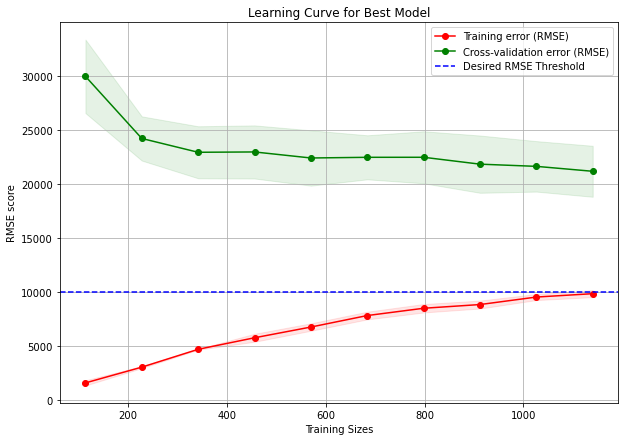

In [17]:
from sklearn.model_selection import learning_curve


estimator = GradientBoostingRegressor(**best_params)

train_sizes, train_scores, test_scores = learning_curve(estimator,trs,train['SalePrice'],cv=5,
                                                        train_sizes = np.linspace(0.1, 1.0, 10), n_jobs=-1,scoring=scorer)
train_scores = -train_scores
test_scores = -test_scores

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve

plt.figure(figsize=(10,7))
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training error (RMSE)")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation error (RMSE)")
plt.axhline(y=10000, color='b', linestyle='--',label='Desired RMSE Threshold')
plt.title('Learning Curve for Best Model')
plt.xlabel('Training Sizes')
plt.ylabel('RMSE score')
plt.legend(loc="best")



For given problem we must define desired RMSE and it should be not more than 10000. For. e.g. if we predict the given propery sale price say 200K then it would not surprise buyer if he hears actual sale price within range 190K to 210K. 

From above graph, it is observed that our training error lies within desired performance range, while cross validation RMSE is far away and above the desired performance. Also distance between training curve and cross validation curve is large. Overall it indicates that current model has suffered with high variance issue. But cross validation score seems slowly decreasing with training size because more samples cause reduction in variance. 

For final test data we would be using whole training set. Therefore, we may obtain more improved performance on test set than expected.

In [18]:
model = GradientBoostingRegressor(**best_params).fit(trs,train['SalePrice'])


pred = model.predict(tes)

submission = pd.DataFrame({'Id':test['Id'].astype(int),'SalePrice':pred})
submission.to_csv('submission.csv',index=False)

We have obtained Test score(RMSE):14060 which seems better than cross validation score. It means adding more data improved result. As well as predictability of model will improve more and more with the data. 

Second thing to note that this score is less better compared to best linear model in previous section. It indicates that linear model are capable to give satisfactory and competitive performance.